Practical 2: Exploring Transfer Learning with Pre-trained Models
# ------------------------------------------------------------------------------
# Practical 2: Transfer Learning with Pre-trained Model (VGG16)
# Course: Computer Vision
# Objective: Use a pre-trained VGG16 model + fine-tuning on a small custom dataset
# Dataset: Cats vs Dogs (binary classification)
# Tools: TensorFlow 2.x + Keras + pre-trained VGG16


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import preprocess_input

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
print("Downloading Cats vs Dogs dataset...")

_URL = 'https://download.mlcc.google.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file(
    'cats_and_dogs.zip',
    origin=_URL,
    extract=True
)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

print("Dataset loaded successfully!")

Dataset loaded successfully!


In [3]:
# Re-evaluate paths based on kernel state for path_to_zip
# path_to_zip was found to be '/root/.keras/datasets/cats_and_dogs_extracted' in the kernel state.
# The actual dataset content is typically in a subdirectory named 'cats_and_dogs_filtered' inside the extracted folder.
corrected_PATH = os.path.join(path_to_zip, 'cats_and_dogs_filtered')
corrected_train_dir = os.path.join(corrected_PATH, 'train')
corrected_validation_dir = os.path.join(corrected_PATH, 'validation')

train_cats = len(os.listdir(os.path.join(corrected_train_dir, 'cats')))
train_dogs = len(os.listdir(os.path.join(corrected_train_dir, 'dogs')))
val_cats = len(os.listdir(os.path.join(corrected_validation_dir, 'cats')))
val_dogs = len(os.listdir(os.path.join(corrected_validation_dir, 'dogs')))

print(f"Training Cats: {train_cats}")
print(f"Training Dogs: {train_dogs}")
print(f"Validation Cats: {val_cats}")
print(f"Validation Dogs: {val_dogs}")

Training Cats: 1000
Training Dogs: 1000
Validation Cats: 500
Validation Dogs: 500


In [4]:
print("path_to_zip =", path_to_zip)

path_to_zip = /root/.keras/datasets/cats_and_dogs_extracted


In [5]:
!ls /root/.keras/datasets/cats_and_dogs_extracted/cats_and_dogs_filtered


train  validation  vectorize.py


In [6]:
BASE_DIR = "/root/.keras/datasets/cats_and_dogs_extracted/cats_and_dogs_filtered"

train_dir = os.path.join(BASE_DIR, "train")
validation_dir = os.path.join(BASE_DIR, "validation")


### Step 2

In [7]:
IMG_SIZE = (160, 160)          # VGG16 usually expects 224×224, but 160 is faster for demo
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
print("Train exists:", os.path.exists(train_dir))
print("Validation exists:", os.path.exists(validation_dir))

print("Train folders:", os.listdir(train_dir))
print("Cats:", len(os.listdir(os.path.join(train_dir, "cats"))))
print("Dogs:", len(os.listdir(os.path.join(train_dir, "dogs"))))


Train exists: True
Validation exists: True
Train folders: ['cats', 'dogs']
Cats: 1000
Dogs: 1000


In [9]:
base_model = VGG16(weights='imagenet',
                   include_top=False,           # remove final dense layers
                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
# Freeze the base model (very important in transfer learning)
base_model.trainable = False


In [10]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),          # better than Flatten for conv base
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')     # binary classification → sigmoid
])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [12]:
print("\nPhase 1: Training top layers only...")
history_phase1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1
)



Phase 1: Training top layers only...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 491ms/step - accuracy: 0.5218 - loss: 0.7284 - val_accuracy: 0.6800 - val_loss: 0.6091
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.6243 - loss: 0.6446 - val_accuracy: 0.7870 - val_loss: 0.5463
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - accuracy: 0.6834 - loss: 0.5875 - val_accuracy: 0.8220 - val_loss: 0.4984
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step - accuracy: 0.7295 - loss: 0.5482 - val_accuracy: 0.8300 - val_loss: 0.4657
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step - accuracy: 0.7699 - loss: 0.5120 - val_accuracy: 0.8330 - val_loss: 0.4369
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 319ms/step - accuracy: 0.7775 - loss: 0.4938 - val_accuracy: 0.8340 - val_loss: 0.4167
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 335ms/step - accuracy: 0.7815 - loss: 0.4802 - val_accuracy: 0.8450 - val_loss: 0.3949
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 306ms/step - accuracy: 0.7871 - loss: 0.4585 - val_accu

In [13]:
print("\nUnfreezing last few conv blocks for fine-tuning...")
base_model.trainable = True
# Freeze all layers except the last 4 blocks (example)
for layer in base_model.layers[:-16]:
    layer.trainable = False
# Re-compile with lower learning rate (very important!)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
print("Phase 2: Fine-tuning...")
history_phase2 = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1
)




Unfreezing last few conv blocks for fine-tuning...
Phase 2: Fine-tuning...
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 612ms/step - accuracy: 0.8479 - loss: 0.3239 - val_accuracy: 0.9440 - val_loss: 0.1484
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 366ms/step - accuracy: 0.9278 - loss: 0.1806 - val_accuracy: 0.9590 - val_loss: 0.1171
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 369ms/step - accuracy: 0.9387 - loss: 0.1491 - val_accuracy: 0.9350 - val_loss: 0.1435
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 362ms/step - accuracy: 0.9523 - loss: 0.1180 - val_accuracy: 0.9540 - val_loss: 0.1070
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 367ms/step - accuracy: 0.9716 - loss: 0.0850 - val_accuracy: 0.9650 - val_loss: 0.0878
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 369ms/step - accuracy: 0.9705 - loss: 0.0753 - val_accuracy: 0.9660 - val_loss: 0.0941
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 370ms/step - accuracy: 0.9742 - loss: 0.0688 - val_accuracy: 0.9680 - val_loss: 0.0812
Epoch 8/10
63/63 ━━━━

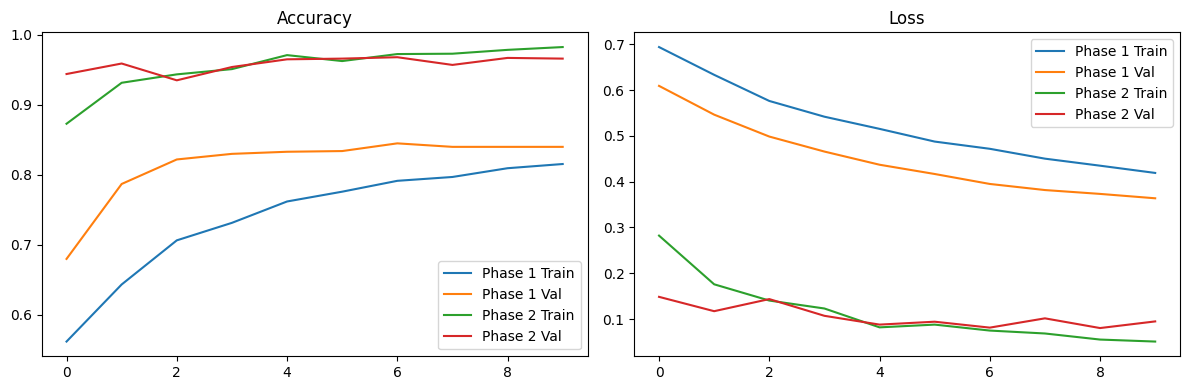

In [14]:
def plot_history(histories, titles):
    plt.figure(figsize=(12, 4))
    for i, hist in enumerate(histories):
        plt.subplot(1, 2, 1)
        plt.plot(hist.history['accuracy'], label=f'{titles[i]} Train')
        plt.plot(hist.history['val_accuracy'], label=f'{titles[i]} Val')
        plt.title('Accuracy')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], label=f'{titles[i]} Train')
        plt.plot(hist.history['val_loss'], label=f'{titles[i]} Val')
        plt.title('Loss')
        plt.legend()
    plt.tight_layout()
    plt.show()
plot_history([history_phase1, history_phase2], ['Phase 1', 'Phase 2'])


In [15]:
loss, acc = model.evaluate(validation_generator, verbose=0)
print(f"\nFinal validation accuracy: {acc:.4f} ({acc*100:.2f}%)")
# Optional: Save model
# model.save("vgg16_cats_dogs_transfer.h5")



Final validation accuracy: 0.9660 (96.60%)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


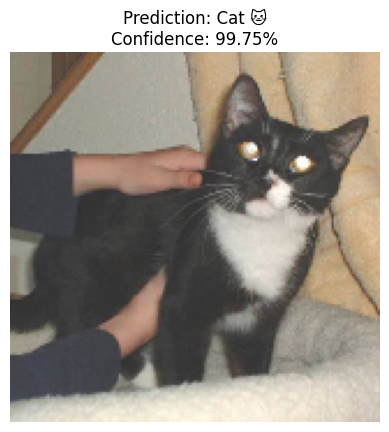

Raw model output: 0.0025


In [16]:
# ==========================
# PREDICTION CELL
# ==========================

from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

# Path to a test image (change this)
img_path = "/root/.keras/datasets/cats_and_dogs_extracted/cats_and_dogs_filtered/validation/cats/cat.2000.jpg"
# Example for dog:
# img_path = "/root/.keras/datasets/cats_and_dogs_extracted/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg"

# Load and preprocess image
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = img_array / 255.0               # same rescaling as training
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)[0][0]

# Decode result
if prediction > 0.5:
    label = "Dog 🐶"
    confidence = prediction * 100
else:
    label = "Cat 🐱"
    confidence = (1 - prediction) * 100

# Display image
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {label}\nConfidence: {confidence:.2f}%")
plt.show()

print(f"Raw model output: {prediction:.4f}")


Saving download.jpg to download (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


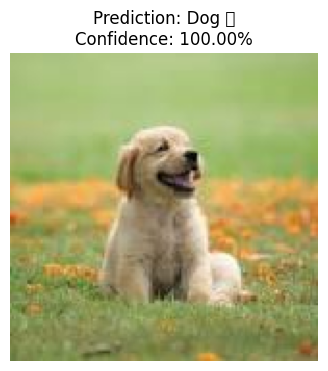

Raw sigmoid output: 1.0000


In [28]:
# ==========================
# USER IMAGE UPLOAD + PREDICTION
# ==========================

from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

# Upload image
uploaded = files.upload()

# Get uploaded image path
img_path = list(uploaded.keys())[0]

# Load & preprocess image
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = img_array / 255.0          # same preprocessing as training
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)[0][0]

# Decode prediction
if prediction > 0.5:
    label = "Dog 🐶"
    confidence = prediction * 100
else:
    label = "Cat 🐱"
    confidence = (1 - prediction) * 100

# Display result
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {label}\nConfidence: {confidence:.2f}%")
plt.show()

print(f"Raw sigmoid output: {prediction:.4f}")


# CNN Model



In [18]:
# ==========================
# CNN MODEL (FINAL FIXED VERSION)
# ==========================

from tensorflow.keras import layers, models

cnn_model = models.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    layers.Conv2D(32, (3,3), activation='relu', name="conv1"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', name="conv2"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', name="conv3"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,401,921 (20.61 MB)

 Trainable params: 5,401,921 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
print("Training Simple CNN...")
history_cnn = cnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1
)




Training Simple CNN...
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 334ms/step - accuracy: 0.4809 - loss: 0.7404 - val_accuracy: 0.5010 - val_loss: 0.6930
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 251ms/step - accuracy: 0.5030 - loss: 0.6928 - val_accuracy: 0.5660 - val_loss: 0.6829
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 251ms/step - accuracy: 0.5455 - loss: 0.6893 - val_accuracy: 0.5000 - val_loss: 0.6902
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 271ms/step - accuracy: 0.5309 - loss: 0.6886 - val_accuracy: 0.5290 - val_loss: 0.6695
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 252ms/step - accuracy: 0.5698 - loss: 0.6682 - val_accuracy: 0.5690 - val_loss: 0.6671
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step - accuracy: 0.5858 - loss: 0.6650 - val_accuracy: 0.5570 - val_loss: 0.6474
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 253ms/step - accuracy: 0.6277 - loss: 0.6515 - val_accuracy: 0.6290 - val_loss: 0.6305
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.6327 - 

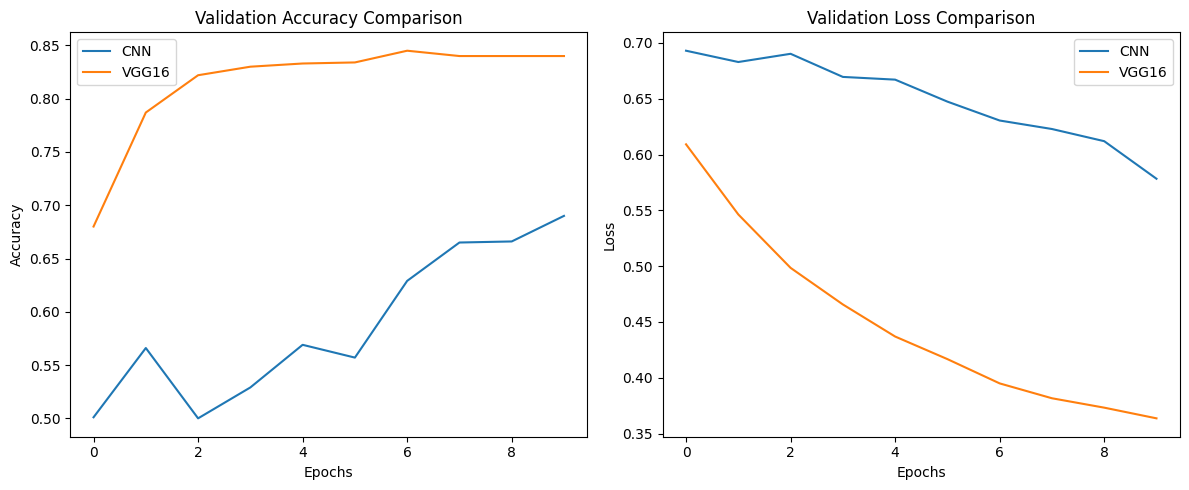

In [20]:
# ==========================
# PERFORMANCE COMPARISON
# ==========================

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_cnn.history['val_accuracy'], label='CNN')
plt.plot(history_phase1.history['val_accuracy'], label='VGG16')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_cnn.history['val_loss'], label='CNN')
plt.plot(history_phase1.history['val_loss'], label='VGG16')
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
# ==========================
# MODEL ARCHITECTURE VISUALIZATION
# ==========================

from tensorflow.keras.utils import plot_model

plot_model(
    cnn_model,
    show_shapes=True,
    show_layer_names=True,
    to_file="cnn_model.png"
)

plot_model(
    model,   # VGG16 transfer learning model
    show_shapes=True,
    show_layer_names=True,
    to_file="vgg16_model.png"
)

print("Model architecture diagrams saved!")


Model architecture diagrams saved!


In [22]:
# ==========================
# ACCURACY COMPARISON TABLE
# ==========================

import pandas as pd

# Evaluate models
cnn_loss, cnn_acc = cnn_model.evaluate(validation_generator, verbose=0)
vgg_loss, vgg_acc = model.evaluate(validation_generator, verbose=0)

# Create comparison table
accuracy_table = pd.DataFrame({
    "Model": ["Simple CNN", "VGG16 (Transfer Learning)"],
    "Validation Accuracy (%)": [cnn_acc * 100, vgg_acc * 100],
    "Validation Loss": [cnn_loss, vgg_loss]
})

accuracy_table


,Model,Validation Accuracy (%),Validation Loss
0,Simple CNN,69.000000,0.578294
1,VGG16 (Transfer Learning),96.600002,0.094740
